In [11]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

# added
from folder import KFolder
import numpy as np
import os
from PIL import Image
from Augmentation import ToAugmantate
from shuffle import shuffle_data
import pickle
from load_data import serialize_model, deserialize_model

In [12]:
def loss_plot(hist):
    train_epochs = list(range(1, len(hist['loss']) + 1))
    valid_epochs = list(range(1, len(hist['val_loss']) + 1))
    train_losses = hist['loss']
    valid_losses = hist['val_loss']

    train_min_loss = min(dict(zip(train_epochs, train_losses)).items(), key=lambda x: x[1])
    valid_min_loss = min(dict(zip(valid_epochs, valid_losses)).items(), key=lambda x: x[1])

    plt.plot(train_epochs, hist['loss'], linewidth=1, color='blue', label='Training Loss')
    plt.plot(train_min_loss[0], train_min_loss[1], color='black', marker='o',
             label=f'Training Best Epoch - {train_min_loss[0]}')
    plt.plot(valid_epochs, hist['val_loss'], linewidth=1, color='red', label='Validation Loss')
    plt.plot(valid_min_loss[0], valid_min_loss[1], color='black', marker='o',
             label=f'Validation Best Epoch - {valid_min_loss[0]}')
    plt.legend(loc='best')
    plt.title(label='Training & Validation Loss')
    plt.xlabel(xlabel='Epochs')
    plt.ylabel(ylabel='Loss')
    plt.show()

In [13]:
def accuracy_plot(hist):
  epochs = list(range(1, len(hist['accuracy']) + 1))

  plt.plot(epochs, hist['accuracy'], marker='o', linewidth=1, label='Training Accuracy', color='blue')
  plt.plot(epochs, hist['val_accuracy'], marker='o', linewidth=1, label='Validation Accuracy', color='red')
  plt.title(label='Training & Validation Accuracy')
  plt.legend(loc='best')
  plt.xlabel(xlabel='Epochs')
  plt.ylabel(ylabel='Accuracy')
  plt.show()

In [26]:
def get_model():
    model = keras.models.Sequential(layers=[
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=(150, 150, 3),
            padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(rate=0.2),
        Dense(units=256, activation='relu'),
        Dense(units=4, activation='softmax')
    ])
    return model

# relu, softmax
# relu -> gelu, softmax -> softplus,
# gelu -> relu, softplus
# relu -> gelu, softplus -> softmax

DON'T RUN EVERY TIME, ONLY IF U WANT TO SHUFFLE TRAIN <-> TESTS

In [ ]:
# import shutil
# output_dir = 'splitted_dataset'
# if os.path.exists(output_dir):
#    shutil.rmtree(output_dir, ignore_errors=True)

# os.makedirs(output_dir)
# import splitfolders
# splitfolders.ratio('dataset', output=output_dir, seed=1337, ratio=(.9, 0.1))

In [27]:
def load_images(path: str, class_id: int) -> list:
    content_list = os.listdir(path)
    files_list = [os.path.join(path, content_thing) for content_thing in content_list if os.path.isfile(os.path.join(path, content_thing))]
    imgs_list = []
    labels_list = []
    for file_path in files_list:
        temp_img = Image.open(file_path)
        numpy_image = np.asarray(temp_img.resize((150,150)))
        imgs_list.append(numpy_image)
        labels_list.append(class_id)
    return imgs_list, labels_list

# load train images
main_path = "splitted_dataset/"
cataract = main_path+"train/cataract"
diabetic_retinopathy = main_path+"train/diabetic_retinopathy"
glaucoma = main_path+"train/glaucoma"
normal = main_path+"train/normal"

In [28]:
images_cataract, labels_cataract = load_images(cataract, 1)
images_diabetic_retinopathy, labels_retinopathy = load_images(diabetic_retinopathy, 2)
images_glaucoma, labels_glaucoma = load_images(glaucoma, 3)
images_normal, labels_normal = load_images(normal, 0)

In [29]:
# merge tables
x = images_cataract+images_diabetic_retinopathy+images_glaucoma+images_normal
y = labels_cataract+labels_retinopathy+labels_glaucoma+labels_normal
x, y = shuffle_data(x, y)
del images_cataract, images_diabetic_retinopathy, images_glaucoma, images_normal, labels_cataract,labels_retinopathy,labels_glaucoma,labels_normal

In [16]:
images_cataract, labels_cataract = load_images(cataract, 1)
images_diabetic_retinopathy, labels_retinopathy = load_images(main_path+"val/diabetic_retinopathy", 2)
images_glaucoma, labels_glaucoma = load_images(main_path+"val/glaucoma", 3)
images_normal, labels_normal = load_images(main_path+"val/normal", 0)

In [17]:
X_test = images_cataract+images_diabetic_retinopathy+images_glaucoma+images_normal
Y_test = labels_cataract+labels_retinopathy+labels_glaucoma+labels_normal
X_test, Y_test = shuffle_data(X_test, Y_test)
del images_cataract, images_diabetic_retinopathy, images_glaucoma, images_normal, labels_cataract,labels_retinopathy,labels_glaucoma,labels_normal

In [18]:
train_data_gen = ToAugmantate()
test_data_gen = ToAugmantate(False)

In [30]:
kfolder = KFolder(5, x, y)

Computing folds


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


In [ ]:
# # import tensorflow as tf
# # from dataset import get_data
# # from model import get_model
# # import os
# # import numpy as np
# # import matplotlib.pyplot as plt
# # import segmentation_models as sm
# # from folder import KFolder
# for i, fold in enumerate(kfolder.folds):
#     callbacks = [tf.keras.callbacks.ModelCheckpoint(f"./best_model_fold_{i}.h5", save_best_only=True, verbose=1)]
#     # callbacks = [tf.keras.callbacks.ModelCheckpoint("./best_model.h5", save_best_only=True, verbose=1)]
#     model = get_model()
#     model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

#     X_train, y_train, X_valid, y_valid = fold

#     model.fit(train_data_gen.flow(X_train, y=y_train, batch_size=8, subset='training'), validation_data=(train_data_gen.flow(X_valid, y_valid, batch_size=8, subset='validation')), batch_size=16, epochs=100, callbacks=callbacks, verbose=1)

#     del model
#     best_model = tf.keras.models.load_model(f"./best_model_fold_{i}.h5")

#     evaluation = best_model.evaluate(X_test, Y_test)

#     with open(f"./results_fold_{i}.txt",'w') as f:
#         f.write(f"test loss: {evaluation[0]}\n")
#         f.write(f"accuracy: {evaluation[1]}\n")
#         f.write(f"dice-score: {evaluation[2]}\n")
#     print(100*'--')


Below presented by Chat GPT, bc above was giving error I had no clue why

In [31]:
best_model = None
best_model_loss = float('inf')
best_model_fold_loss = []
best_model_accuracy = 0.0
best_model_fold_accuracy = []

histories = []

for fold_idx, (x_train, y_train, x_valid, y_valid) in enumerate(kfolder.folds):
    print("Fold:", fold_idx + 1)
    model = get_model()
    optimizer = tf.keras.optimizers.Adam(0.0003)
    # Compile the model
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)

    # Train the model
    history = model.fit(train_data_gen.flow(x_train, y_train, batch_size=32),
                        epochs=35,
                        validation_data=test_data_gen.flow(x_valid, y_valid),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

     # Append loss and accuracy history for this fold
    histories.append(history.history)
    # Evaluate the model on validation data
    loss, accuracy = model.evaluate(test_data_gen.flow(x_valid, y_valid))
    print("Fold Loss:", loss)
    print("Fold Accuracy:", accuracy)
    

    # Save the best model for this fold
    if loss < best_model_loss:
        best_model = model
        best_model_loss = loss
    best_model_fold_loss.append(loss)
    best_model_fold_accuracy.append(accuracy)

print("Accuracy and Loss plots saved as PNG files")
# Print the best model's loss and accuracy for each fold
print("Best Model Loss for each fold:", best_model_fold_loss)
print("Best Model Accuracy for each fold:", best_model_fold_accuracy)

# Save the best overall model
best_model.save('best_model.h5')
print("Best Model saved as 'best_model.h5'")

Fold: 1
Epoch 1/35
95/95 [==============================] - 36s 370ms/step - loss: 1.9937 - accuracy: 0.5775 - val_loss: 0.6824 - val_accuracy: 0.7427 - lr: 3.0000e-04
Epoch 2/35
95/95 [==============================] - 30s 313ms/step - loss: 0.6697 - accuracy: 0.7164 - val_loss: 0.5906 - val_accuracy: 0.7507 - lr: 3.0000e-04
Epoch 3/35
95/95 [==============================] - 30s 319ms/step - loss: 0.5354 - accuracy: 0.7843 - val_loss: 0.5871 - val_accuracy: 0.7282 - lr: 3.0000e-04
Epoch 4/35
95/95 [==============================] - 33s 342ms/step - loss: 0.5132 - accuracy: 0.7853 - val_loss: 0.4865 - val_accuracy: 0.8034 - lr: 3.0000e-04
Epoch 5/35
95/95 [==============================] - 32s 334ms/step - loss: 0.4700 - accuracy: 0.8137 - val_loss: 0.4605 - val_accuracy: 0.8047 - lr: 3.0000e-04
Epoch 6/35
95/95 [==============================] - 31s 327ms/step - loss: 0.4290 - accuracy: 0.8259 - val_loss: 0.4742 - val_accuracy: 0.7929 - lr: 3.0000e-04
Epoch 7/35
95/95 [==============

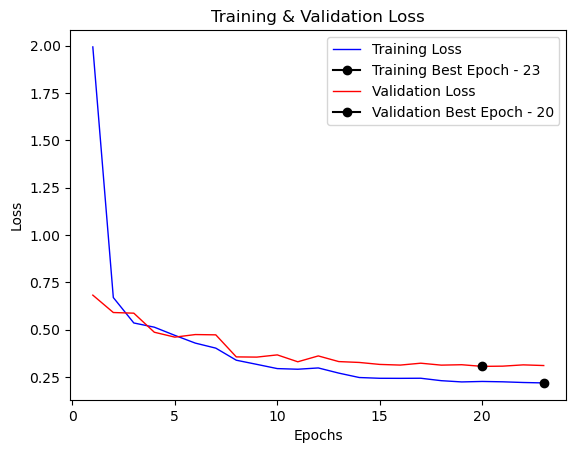

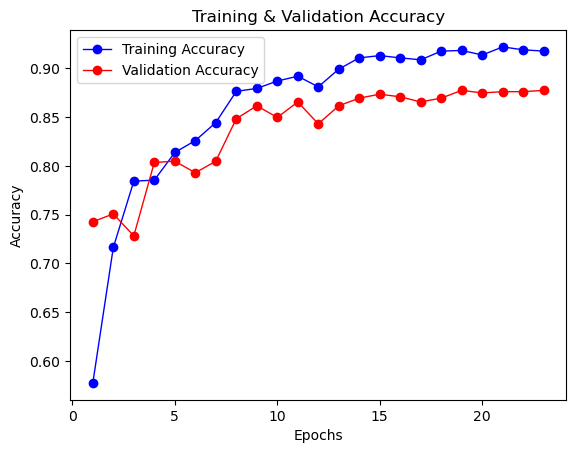

Saved model to disk


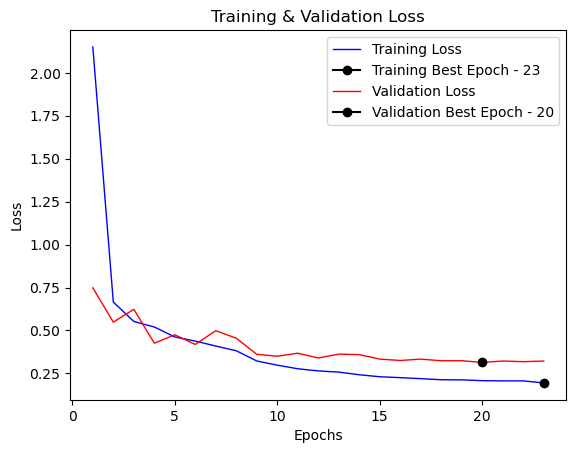

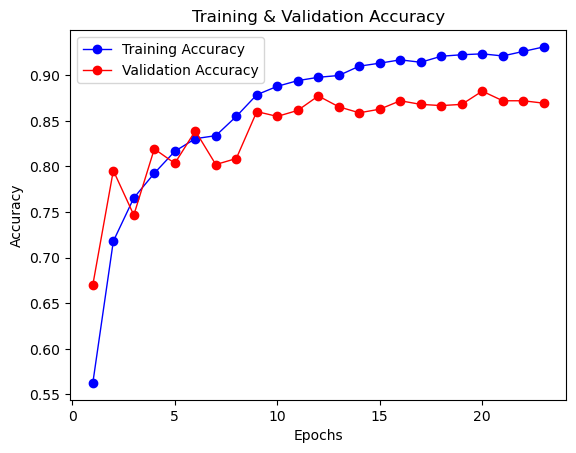

Saved model to disk


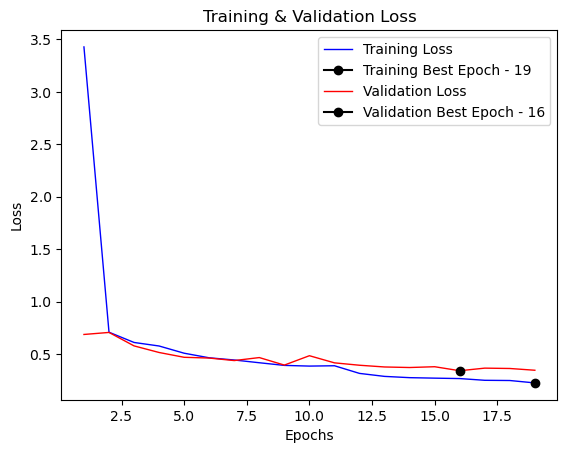

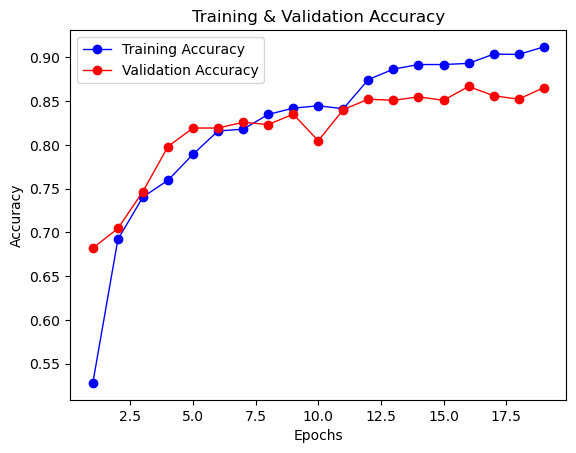

Saved model to disk


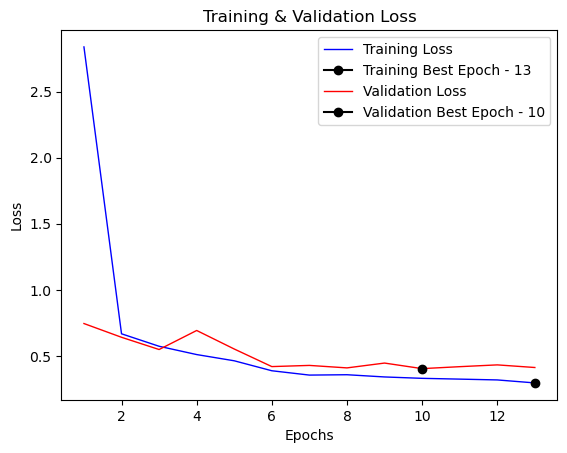

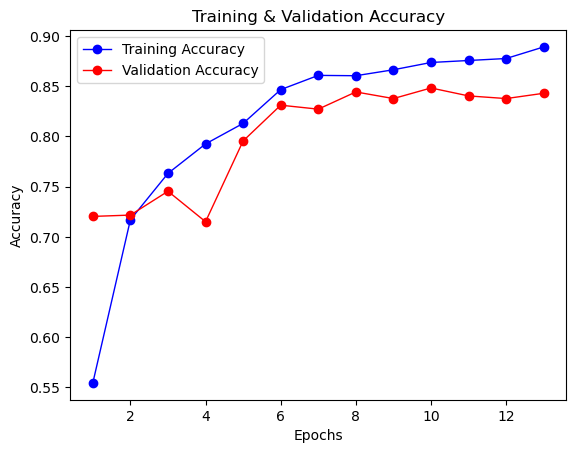

Saved model to disk


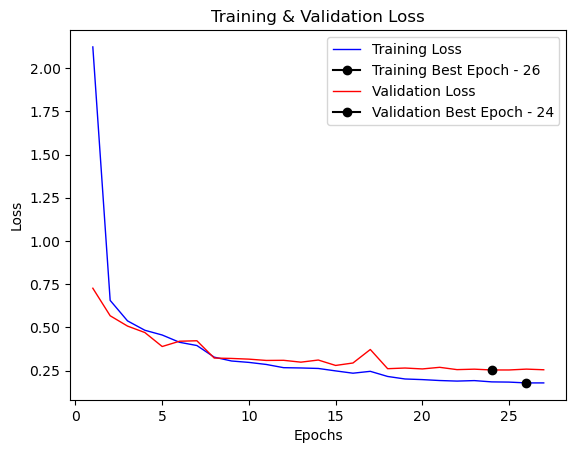

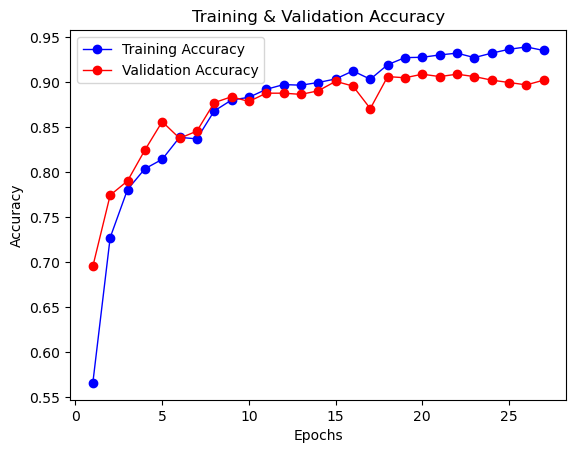

Saved model to disk


In [33]:
model = get_model()
# Convert loss_histories and accuracy_histories to numpy arrays
histories = np.array(histories)
current_funcs = "gelus_&_softmax"
save2_file_name = current_funcs
for i in range(0, len(histories)):
    loss_plot(histories[i])
    accuracy_plot(histories[i])
    serialize_model(model, file_name = f'{save2_file_name}_fold{i+1}', history_model=histories[i], def_path=f'./Model/{current_funcs}/')



In [32]:
save2_file_name = "best_model"
model, history_model = deserialize_model(save2_file_name, def_path="")

# Make predictions
predictions = model.predict(X_test)
eval = model.evaluate(X_test, Y_test)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
confusion_matrix(Y_test, predictions.argmax(axis=1))

Loaded model from disk
40/40 [==============================] - 3s 73ms/step - loss: 0.2432 - accuracy: 0.9178


array([[ 90,   8,   0,  10],
       [ 34, 868,   0,  32],
       [  0,   0, 110,   0],
       [ 11,   8,   0,  82]], dtype=int64)

In [40]:
a = [ 11,   8,   0,  82]
print((a[1]/sum(a))*100)

7.920792079207921
